- GitHub: https://github.com/mahmood1989?tab=repositories
- Email: mahmoodr@ualberta.ca

# Breast Cancer Gene Expression Profiles
# Model 3 - All Features (General + Gene Expression)
In this notebook, I just used general and gene expression data as input features of the model (Columns B to SZ).

## Import Python libraries

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier


import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image as Image

import seaborn as sn

## General structure of training spreadsheet

The source of this dataset can be downloaded through Kaggle:

https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric

In [2]:
df_raw = pd.read_excel('Model_3.xlsx')
df_raw.head(10)

,age_at_diagnosis,type_of_breast_surgery,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,er_status_measured_by_ihc,neoplasm_histologic_grade,her2_status,tumor_other_histologic_subtype,...,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7,death_from_cancer
0,75.65,MASTECTOMY,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,Positve,3.0,Negative,Ductal/NST,...,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354,Living
1,43.19,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,High,0,LumA,Positve,3.0,Negative,Ductal/NST,...,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920,Living
2,48.87,MASTECTOMY,Breast Invasive Ductal Carcinoma,High,1,LumB,Positve,2.0,Negative,Ductal/NST,...,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655,Died of Disease
3,47.68,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,Positve,2.0,Negative,Mixed,...,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828,Living
4,76.97,MASTECTOMY,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,Positve,3.0,Negative,Mixed,...,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223,Died of Disease
5,78.77,MASTECTOMY,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,Positve,3.0,Negative,Ductal/NST,...,0.0395,0.8191,0.1977,-0.2302,-0.5092,-0.3021,0.9357,-0.4217,0.5340,Died of Disease
6,56.45,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,Moderate,1,LumB,Positve,2.0,Negative,Ductal/NST,...,0.0917,1.6814,2.2495,-1.6522,-3.4775,-0.4892,1.1938,-0.1027,0.4331,Living
7,89.08,BREAST CONSERVING,Breast Mixed Ductal and Lobular Carcinoma,Moderate,0,claudin-low,Positve,2.0,Negative,Mixed,...,-0.3588,2.4959,0.3744,-0.7101,-2.1453,-1.3027,-0.2308,-0.3450,-0.2023,Died of Other Causes
8,86.41,BREAST CONSERVING,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,Positve,3.0,Negative,Ductal/NST,...,-0.1405,-0.9780,-0.3030,-0.1640,1.0783,1.8263,-0.5965,0.1502,-0.8837,Died of Other Causes
9,84.22,MASTECTOMY,Breast Invasive Lobular Carcinoma,High,0,Her2,Negative,2.0,Negative,Lobular,...,-0.4788,3.6125,1.9925,0.2253,-0.8414,1.7093,-0.6921,0.6906,-0.8006,Died of Disease


There are 1904 attributes from 510 different fearures. 1 feature (death_from_cancer) is the output feature.

In [4]:
df_raw.shape

(1904, 511)

There are many null cells and we need to delete them.

In [5]:
df_raw.isna().sum()

age_at_diagnosis           0
type_of_breast_surgery    22
cancer_type_detailed      15
cellularity               54
chemotherapy               0
                          ..
tulp4                      0
ugt2b15                    0
ugt2b17                    0
ugt2b7                     0
death_from_cancer          1
Length: 511, dtype: int64

After deleting the null row, we will have 1498 attributes. 

In [6]:
df_raw.dropna(inplace = True)

In [7]:
df_raw.shape

(1498, 511)

## Convert string variables to categorical classes

In [8]:
df_raw.dtypes

age_at_diagnosis          float64
type_of_breast_surgery     object
cancer_type_detailed       object
cellularity                object
chemotherapy                int64
                           ...   
tulp4                     float64
ugt2b15                   float64
ugt2b17                   float64
ugt2b7                    float64
death_from_cancer          object
Length: 511, dtype: object

df_general is the dataset corresponding to general features of the dataset.

In [9]:
df_general = df_raw[df_raw.columns[0:21]].copy()

In [10]:
df_general['death_from_cancer'] = df_raw['death_from_cancer'].copy()

In [11]:
df_general.shape

(1498, 22)

df_gene is the dataset corresponding to gene-expression features of the dataset.

In [12]:
df_gene = df_raw[df_raw.columns[21:]].copy()

In [13]:
df_gene.shape

(1498, 490)

### 1. Binary (tertiary) variables in df_general

In [14]:
df_general['type_of_breast_surgery'].replace('BREAST CONSERVING', 1, inplace = True)
df_general['type_of_breast_surgery'].replace('MASTECTOMY', 0, inplace = True)

In [15]:
df_general['cellularity'].replace('High', 2, inplace = True)
df_general['cellularity'].replace('Moderate', 1, inplace = True)
df_general['cellularity'].replace('Low', 0, inplace = True)

In [16]:
df_general['er_status_measured_by_ihc'].replace('Positve', 1, inplace = True)
df_general['er_status_measured_by_ihc'].replace('Negative', 0, inplace = True)

In [17]:
df_general['her2_status'].replace('Positive', 1, inplace = True)
df_general['her2_status'].replace('Negative', 0, inplace = True)

In [18]:
df_general['inferred_menopausal_state'].replace('Post', 1, inplace = True)
df_general['inferred_menopausal_state'].replace('Pre', 0, inplace = True)

In [19]:
df_general['pr_status'].replace('Positive', 1, inplace = True)
df_general['pr_status'].replace('Negative', 0, inplace = True)

The output ('death_from_cancer') is the string type with three categories as:
- Living (Class 0)
- Died of Other Causes (Class 0)
- Died of Disease (Class 1)
If a patient dies because of cancer, we categorize it as Class 1, otherwise Class 0 is assigned.

In [20]:
df_general['death_from_cancer'].replace('Living', 0, inplace = True)
df_general['death_from_cancer'].replace('Died of Other Causes', 0, inplace = True)
df_general['death_from_cancer'].replace('Died of Disease', 1, inplace = True)

In [21]:
df_gene['death_from_cancer'].replace('Living', 0, inplace = True)
df_gene['death_from_cancer'].replace('Died of Other Causes', 0, inplace = True)
df_gene['death_from_cancer'].replace('Died of Disease', 1, inplace = True)

### 2. One Hot Encodding 

The following features are converted to dummy input variables.

In [22]:
df_general = pd.get_dummies(data = df_general, columns = ['cancer_type_detailed', 'pam50_+_claudin-low_subtype',\
'tumor_other_histologic_subtype', 'integrative_cluster', 'oncotree_code', '3-gene_classifier_subtype'])

Now we have 54 input features in df_general. 1 feature in the output data.

In [23]:
df_general.shape

(1498, 55)

## Normalization of input parameters

The following float features are normalzied to have a range from 0 to 1.

### 1. General dataset (df_general)

In [24]:
df_norm_general = pd.DataFrame()
columns_norm_general = ['age_at_diagnosis', 'lymph_nodes_examined_positive', 'mutation_count', \
                        'nottingham_prognostic_index', 'tumor_size'] 
df_norm_general = df_general[columns_norm_general].copy()

In [25]:
df_norm_general = df_norm_general.apply(lambda x: (x - x.min(axis = 0)) / ((x.max(axis = 0)) - (x.min(axis = 0))))

In [26]:
df_general[columns_norm_general] = df_norm_general[columns_norm_general]

### 2. Gene dataset (df_gene)

In [27]:
df_norm_gene = pd.DataFrame()
df_norm_gene = df_gene[df_gene.columns[0:489]].copy()

In [28]:
df_norm_gene = df_norm_gene.apply(lambda x: (x - x.min(axis = 0)) / ((x.max(axis = 0)) - (x.min(axis = 0))))

In [29]:
df_gene[df_gene.columns[0:489]] = df_norm_gene.copy()

### Concatenate both datasets

We have 1489 attributes from 543 input features. 1 feature (death_from_cancer) is the output feature.

In [34]:
df = pd.concat([df_general.drop('death_from_cancer', axis = 'columns'), df_gene], axis = 1)

In [35]:
df.shape

(1498, 544)

## Univariate Feature Selection

In [36]:
# The input data of this function is df2_regression or df2_classification

def Univariate_Selection (df2, n_features):
    X = df2.drop('death_from_cancer', axis = 'columns')
    y = df2['death_from_cancer']
    
    bestfeatures = SelectKBest(score_func=chi2, k=10)
    fit = bestfeatures.fit(X,y)
    
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    
    feature_Scores = pd.concat([dfcolumns,dfscores], axis=1)
    feature_Scores.columns = ['Specs','Score']
    
    Top_features = feature_Scores.nlargest(n_features,'Score')
    
    X_featured_US = pd.DataFrame()  
    for ii in Top_features['Specs']:
        X_featured_US[ii] = X[ii]

    X = X_featured_US.copy()
    X = np.array(X)    
    y = np.array(y)
             
    
    print(Top_features)
    
    return(X, y)


# Machine Learning Models
In this section, we test the performance of different classification models.

## 1. Random Forest
We use Univariate_Selection and choose n_feature = 100 as the optimum number of features out of 54 features.

In [37]:
X, y = Univariate_Selection (df, n_features = 100)

                                              Specs      Score
37                            integrative_cluster_5  45.582306
6                                       her2_status  32.948072
3                                      chemotherapy  32.422593
51   3-gene_classifier_subtype_ER+/HER2- Low Prolif  31.215246
53                  3-gene_classifier_subtype_HER2+  29.915362
..                                              ...        ...
24                   pam50_+_claudin-low_subtype_NC   0.519782
412                                           lama2   0.509191
261                                           mmp12   0.507938
272                                           mmp25   0.502321
197                                            csf1   0.500158

[100 rows x 2 columns]


There are several important hyperprameters that should be optimized in the Random Forest model. We use GridSearchCV to find the optimum values of these hyperparameters that result in the maximum accuracy. The algorithm came up with the following values:

ccp_alpha = 0.001, max_depth = 50, max_leaf_nodes = 50, n_estimators = 100

In [38]:
param_grid = [
    {'ccp_alpha' : [0.0005, 0.001, 0.005, 0.01],
     'max_depth' : [20, 30, 40, 50],
     'max_leaf_nodes' : [30, 40, 50],
     'n_estimators' : [50, 75, 100, 125]   
    }
]

optimal_params = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, scoring = 'accuracy')

optimal_params.fit(X, y)

print(optimal_params.best_params_)

{'ccp_alpha': 0.001, 'max_depth': 50, 'max_leaf_nodes': 50, 'n_estimators': 100}


We use K-fold cross validation to get the average of accuracy over different cross validation sets.

In [39]:
Random_forest_models = cross_val_score(RandomForestClassifier(ccp_alpha = 0.001, max_depth = 50, max_leaf_nodes = 50, \
                                                              n_estimators = 100),X, y,cv = 10)
Random_forest_models

array([0.72      , 0.74666667, 0.68      , 0.71333333, 0.64      ,
       0.68666667, 0.72666667, 0.67333333, 0.73825503, 0.75838926])

In [40]:
np.mean(Random_forest_models)

0.708331096196868

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [42]:
Random_forest = RandomForestClassifier(ccp_alpha = 0.001, max_depth = 50, max_leaf_nodes = 50, n_estimators = 100)

In [43]:
Random_forest.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.001, max_depth=50, max_leaf_nodes=50)

Model accuracy is on test data in around 0.73 which is higher than the accuracy of Random Forest in Model 1 and 2.

In [44]:
Random_forest.score(X_test, y_test)

0.73

In [45]:
y_predicted = Random_forest.predict(X_test)

Text(69.0, 0.5, 'Truth')

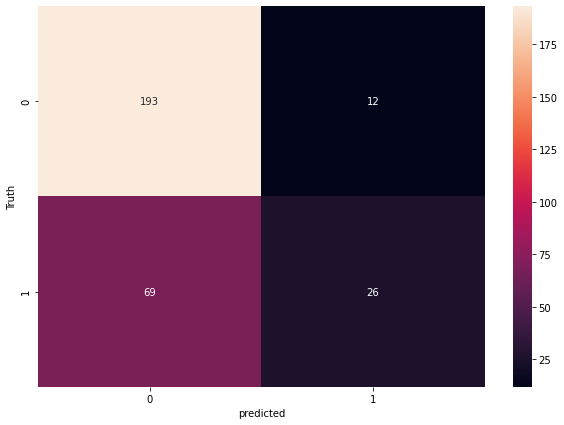

In [46]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

F-Score for Class = 0 is 0.83 which is the highest value of Random Forest among all models. F-score of Class = 1 is 0.39 which improved significantly compared to Model 1 and 2. Similarly, F-score of Class = 0 is 0.83 which is very good. The weighted average F-score is 0.69.

In [47]:
print(classification_report(y_test, y_predicted, zero_division = False))

              precision    recall  f1-score   support

           0       0.74      0.94      0.83       205
           1       0.68      0.27      0.39        95

    accuracy                           0.73       300
   macro avg       0.71      0.61      0.61       300
weighted avg       0.72      0.73      0.69       300



## 2. Gradient Boost

Similar to the Random Forest model, we use Univariate_Selection and n_feature = 100 as the optimum number of features.

In [48]:
X, y = Univariate_Selection (df, n_features = 100)

                                              Specs      Score
37                            integrative_cluster_5  45.582306
6                                       her2_status  32.948072
3                                      chemotherapy  32.422593
51   3-gene_classifier_subtype_ER+/HER2- Low Prolif  31.215246
53                  3-gene_classifier_subtype_HER2+  29.915362
..                                              ...        ...
24                   pam50_+_claudin-low_subtype_NC   0.519782
412                                           lama2   0.509191
261                                           mmp12   0.507938
272                                           mmp25   0.502321
197                                            csf1   0.500158

[100 rows x 2 columns]


We use GridSearchCV to find the optimum values of the hyperparameters, in particular learning rate.

In [49]:
param_grid = [
    {'learning_rate' : [0.001, 0.01, 0.1, 0.15],
     'n_estimators' : [50, 80, 100, 150]
    }
]

optimal_params = GridSearchCV(GradientBoostingClassifier(), param_grid, cv = 5, scoring = 'accuracy')

optimal_params.fit(X, y)

print(optimal_params.best_params_, optimal_params.best_score_)

{'learning_rate': 0.15, 'n_estimators': 50} 0.7089520624303234


In [50]:
Boost_models = cross_val_score(GradientBoostingClassifier(learning_rate = 0.15, n_estimators = 50),X, y,cv = 10)
Boost_models

array([0.72666667, 0.74666667, 0.7       , 0.70666667, 0.61333333,
       0.66666667, 0.66666667, 0.68      , 0.72483221, 0.79194631])

In [51]:
np.mean(Boost_models)

0.7023445190156599

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [53]:
gBoostClassifier = GradientBoostingClassifier(learning_rate = 0.15, n_estimators = 50)
gBoostClassifier.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.15, n_estimators=50)

The accuracy of Gradient Boost on test data is 0.71.

In [54]:
gBoostClassifier.score(X_test, y_test)

0.71

In [55]:
y_predicted = gBoostClassifier.predict(X_test)

Gradient boost works really good in prediction of Class = 1 compared to Random Forest.

Text(69.0, 0.5, 'Truth')

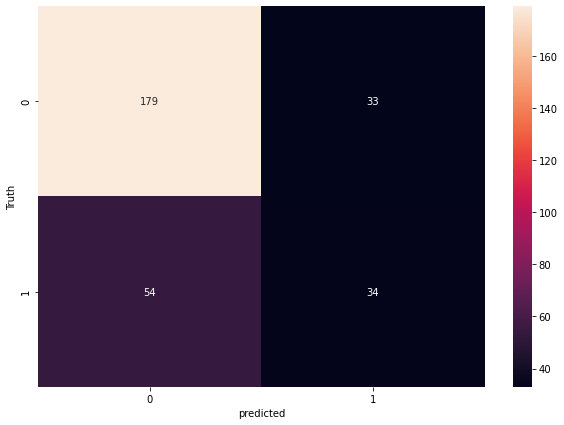

In [56]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

F-Score for Class = 0 is 0.80 which is satisfactory. F-score of Class = 1 is 0.44 which has improved significantly compared to F-score in Model 1 and 2. The weighted average F-score is 0.70, indicating the best performance among all models so far.

In [57]:
print(classification_report(y_test, y_predicted, zero_division = False))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80       212
           1       0.51      0.39      0.44        88

    accuracy                           0.71       300
   macro avg       0.64      0.62      0.62       300
weighted avg       0.69      0.71      0.70       300



## 3. Neural Network

In this part, we use a shallow neural network for binary classification.

In [58]:
X, y = Univariate_Selection (df, n_features = 100)

                                              Specs      Score
37                            integrative_cluster_5  45.582306
6                                       her2_status  32.948072
3                                      chemotherapy  32.422593
51   3-gene_classifier_subtype_ER+/HER2- Low Prolif  31.215246
53                  3-gene_classifier_subtype_HER2+  29.915362
..                                              ...        ...
24                   pam50_+_claudin-low_subtype_NC   0.519782
412                                           lama2   0.509191
261                                           mmp12   0.507938
272                                           mmp25   0.502321
197                                            csf1   0.500158

[100 rows x 2 columns]


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [70]:
X_train.shape

(1198, 100)

In [71]:
NN = keras.Sequential([
    
    keras.layers.Dense(100, input_shape = (100, ), activation = 'relu'),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(30, activation = 'relu'),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1, activation = 'sigmoid'), 
])

NN.compile(optimizer = 'adam',
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  
history_class = NN.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 1s 11ms/step - loss: 0.7088 - accuracy: 0.5993 - val_loss: 0.6421 - val_accuracy: 0.6567
Epoch 2/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6442 - accuracy: 0.6586 - val_loss: 0.6319 - val_accuracy: 0.6567
Epoch 3/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6423 - accuracy: 0.6586 - val_loss: 0.6240 - val_accuracy: 0.6600
Epoch 4/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6402 - accuracy: 0.6586 - val_loss: 0.6169 - val_accuracy: 0.6600
Epoch 5/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6184 - accuracy: 0.6628 - val_loss: 0.6109 - val_accuracy: 0.6667
Epoch 6/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6169 - accuracy: 0.6861 - val_loss: 0.6104 - val_accuracy: 0.6667
Epoch 7/100
38/38 [==============================] - 0s 5ms/step - loss: 0.6137 - accuracy: 0.6928 - val_loss: 0.6057 - val_accuracy: 0.6600
Epoch 8/100


Epoch 59/100
38/38 [==============================] - 0s 5ms/step - loss: 0.5027 - accuracy: 0.7571 - val_loss: 0.5897 - val_accuracy: 0.7067
Epoch 60/100
38/38 [==============================] - 0s 5ms/step - loss: 0.5043 - accuracy: 0.7387 - val_loss: 0.6056 - val_accuracy: 0.7000
Epoch 61/100
38/38 [==============================] - 0s 5ms/step - loss: 0.5066 - accuracy: 0.7396 - val_loss: 0.5848 - val_accuracy: 0.6967
Epoch 62/100
38/38 [==============================] - 0s 5ms/step - loss: 0.4935 - accuracy: 0.7663 - val_loss: 0.5892 - val_accuracy: 0.6833
Epoch 63/100
38/38 [==============================] - 0s 5ms/step - loss: 0.4930 - accuracy: 0.7563 - val_loss: 0.5996 - val_accuracy: 0.6967
Epoch 64/100
38/38 [==============================] - 0s 5ms/step - loss: 0.4841 - accuracy: 0.7554 - val_loss: 0.5893 - val_accuracy: 0.6833
Epoch 65/100
38/38 [==============================] - 0s 5ms/step - loss: 0.4957 - accuracy: 0.7621 - val_loss: 0.5858 - val_accuracy: 0.6833
Epoch 

This NN model has 13,161 parameters that should be optimized by backpropagation.

In [72]:
NN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 30)                3030      
                                                                 
 dropout_5 (Dropout)         (None, 30)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 31        
                                                                 
Total params: 13,161
Trainable params: 13,161
Non-trainable params: 0
_________________________________________________________________


The following figures show the profiles of "loss" and "accuracy" with respect to epochs for the training and validation (test) datasets.

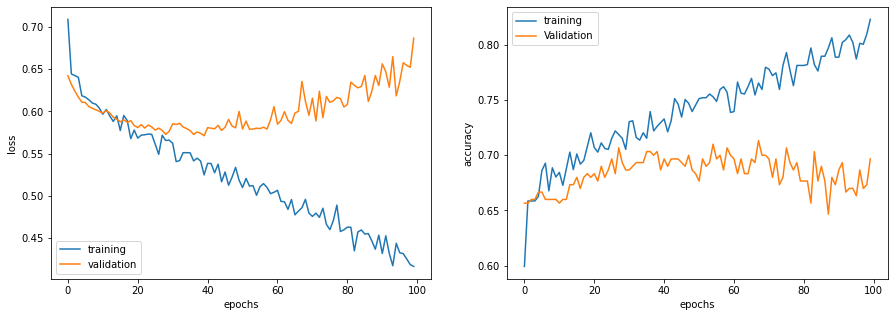

In [73]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.plot(history_class.history['loss'], label = 'training')
plt.plot(history_class.history['val_loss'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_class.history['accuracy'], label = 'training')
plt.plot(history_class.history['val_accuracy'], label = 'Validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()


The accuracy of the NN model on test set is around 0.69.

The accuracy of the NN model on test set is around 0.69.

In [74]:
NN.evaluate(X_test, y_test)

10/10 [==============================] - 0s 3ms/step - loss: 0.6866 - accuracy: 0.6967


[0.6865929365158081, 0.6966666579246521]

In [75]:
y_predicted = NN.predict(X_test)

In [76]:
y_predicted_labels = []

for ii in y_predicted:
    if ii > 0.5:
        y_predicted_labels.append(1)
    elif ii <= 0.5:
        y_predicted_labels.append(0)

Text(69.0, 0.5, 'Truth')

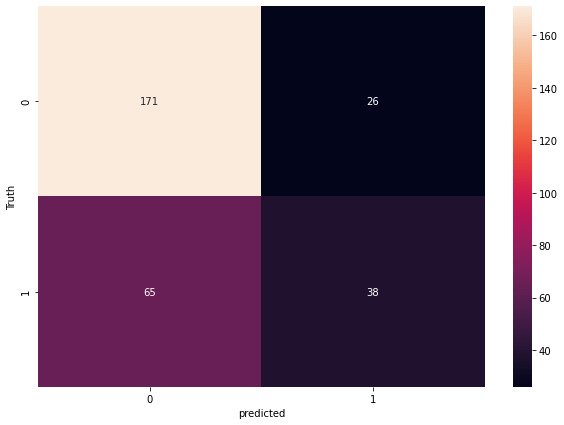

In [77]:
# Let's visualize this confusion matrix in seaborn
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predicted_labels)
plt.figure(figsize = (10, 7))
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel ('predicted')
plt.ylabel('Truth')

F-score of class = 1 has improved significantly to 0.46. The weighted average F-score is 0.67 which is a bit lower than F-score of Gradient Boost. 

In [78]:
print(classification_report(y_test, y_predicted_labels, zero_division = False))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79       197
           1       0.59      0.37      0.46       103

    accuracy                           0.70       300
   macro avg       0.66      0.62      0.62       300
weighted avg       0.68      0.70      0.67       300



## Learning curve - High Bias Problem
### Gradient Boost Model
In this subsection, we want to evaluate the learning curve of the Gradient Boost model. The interpretation of this curve will help us to understand why the accuracy of our model is relatively low.

In [48]:
X, y = Univariate_Selection (df, n_features = 100)

                                                Specs      Score
37                              integrative_cluster_5  45.582306
6                                         her2_status  32.948072
3                                        chemotherapy  32.422593
51     3-gene_classifier_subtype_ER+/HER2- Low Prolif  31.215246
53                    3-gene_classifier_subtype_HER2+  29.915362
22                   pam50_+_claudin-low_subtype_LumA  27.257431
36                              integrative_cluster_3  21.067066
21                   pam50_+_claudin-low_subtype_Her2  19.203529
9                       lymph_nodes_examined_positive  17.360078
1                              type_of_breast_surgery  14.024467
11                        nottingham_prognostic_index  13.966838
35                              integrative_cluster_2  10.138265
12                                          pr_status   8.017459
5                           neoplasm_histologic_grade   6.610283
33  tumor_other_histologi

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.001)

In [80]:
def plot_learning_curve(train_scores, test_scores, train_sizes, fig_name, title, xlabel, ylabel):
    train_mean = 1 - np.mean(train_scores, axis = 1)

    test_mean = 1 - np.mean(test_scores, axis = 1)

    plt.plot(train_sizes, train_mean, '--',  label="Training score")
    plt.plot(train_sizes, test_mean, label="Cross-validation score")

    plt.title(title)
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel) 
    plt.legend(loc="best")
    plt.savefig(fig_name, bbox_inches='tight')

In [81]:
train_sizes, train_scores, test_scores = learning_curve \
(GradientBoostingClassifier(learning_rate = 0.15, n_estimators = 50), \
 X_train, y_train, cv = 5, train_sizes=np.linspace(0.01, 1.0, 30))

Similar to Model 1 with 100 input features, there is a big gap between training and validation errors, suggesting a high variance problem. One way to solve this issue is to add more training data to the dataset. It makes sense because we have 100 input features and only 1498 attributes. Adding more data would reduce the gap between training and validation errors.

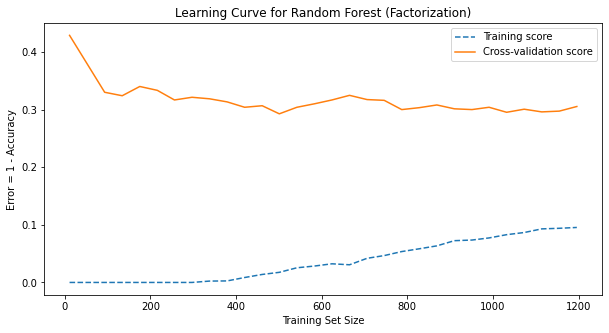

In [82]:
plt.figure(figsize=(10,5))
plot_learning_curve(train_scores,test_scores,train_sizes,"Random_Forest_Curve.png",
           "Learning Curve for Random Forest (Factorization)","Training Set Size","Error = 1 - Accuracy")

### This is end of Model 3